# DataMole Air Pressure Assignment
Working on air pump failures
- Since we are predicting pump failures this is a classification problem. 
- First lets load and look at the data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay, precision_recall_curve, roc_curve, PrecisionRecallDisplay, f1_score, recall_score

In [2]:
pq_raw_data = pq.read_table('data/data.parquet')

In [3]:
df = pq_raw_data.to_pandas()

In [4]:
df.head(5)

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


We see pressure values for different machine cycles per machine ID. Lets check if there are any missing values. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB


In [6]:
df.MachineId.isnull().sum()

0

In [7]:
df.MeasurementId.isnull().sum()

0

In [8]:
df.Pressure.isnull().sum()

0

No null values in df. 

In [9]:
df.Pressure.describe()

count    1.846636e+07
mean     3.338926e-01
std      4.862787e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.017707e-01
max      6.774464e+00
Name: Pressure, dtype: float64

So there are many 0 values, which could be from before the machine begins its cycle. The mean is 0.334. There could be some outliers in the max values as the max value is much larger than the 75% value but since we are going to be computing variables out of this data, these can be ignored for now. 

In [10]:
labels = pd.read_csv('data/labels.csv')

In [11]:
labels.head(10)

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN
5,0_1_1,1,True,False,False
6,0_1_2,-1,NaN,NaN,NaN
7,0_1_3,-1,NaN,NaN,NaN
8,1_0_0,2,False,True,False
9,1_0_1,-1,NaN,NaN,NaN


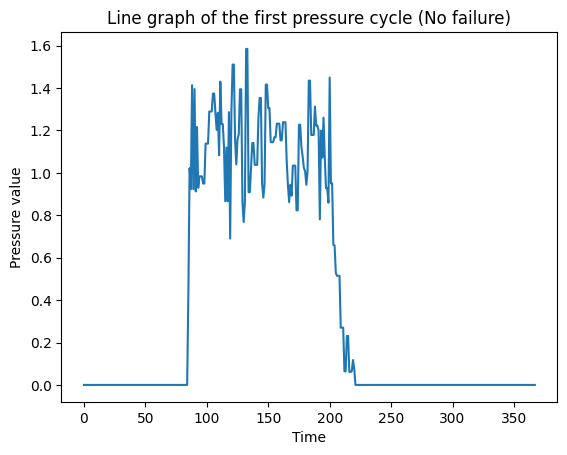

In [12]:
# Simple plot of a machine cycle which did not fail
one_cycle = df[(df['MachineId'] == '0_0_0') & (df['MeasurementId'] == 0)]

plt.plot(range(len(one_cycle)), one_cycle['Pressure'])
plt.title('Line graph of the first pressure cycle (No failure)')
plt.xlabel('Time')
plt.ylabel('Pressure value')
plt.show()

The machine pressure still rises and falls throughout the cycle. 

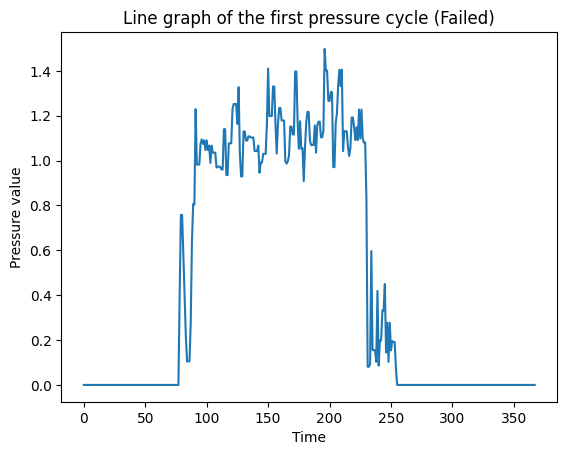

In [13]:
# Simple plot of a machine cycle which failed
one_cycle = df[(df['MachineId'] == '0_0_3') & (df['MeasurementId'] == 0)]

plt.plot(range(len(one_cycle)), one_cycle['Pressure'])
plt.title('Line graph of the first pressure cycle (Failed)')
plt.xlabel('Time')
plt.ylabel('Pressure value')
plt.show()

We can see from the graphs that the pressure does show a large drop at the beginning of the cycle but drops and rises throughout the cycle. The large pressure drop is within the first third of the pressure cycle. Lets have a look at another failed pressure cycle. 

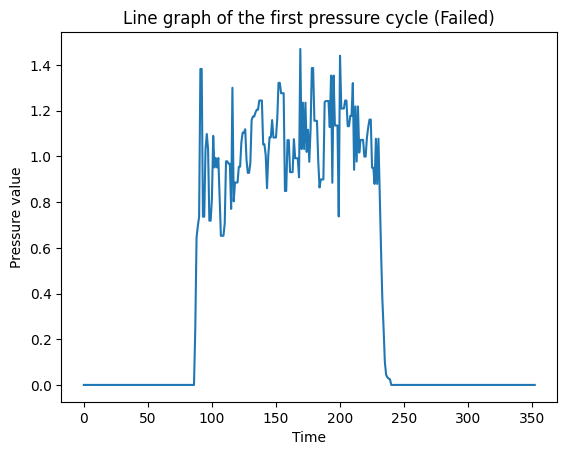

In [14]:
# Simple plot of a machine cycle which failed
one_cycle = df[(df['MachineId'] == '0_1_1') & (df['MeasurementId'] == 1)]

plt.plot(range(len(one_cycle)), one_cycle['Pressure'])
plt.title('Line graph of the first pressure cycle (Failed)')
plt.xlabel('Time')
plt.ylabel('Pressure value')
plt.show()

Here the pattern is less clear. There is no large pressure drop at the beginning of the cycle. 

In [15]:
df.dtypes

MachineId         object
MeasurementId      int64
Pressure         float64
dtype: object

Lets change the MeasurementId to a categorical variable. 

In [16]:
df['MeasurementId'] = df['MeasurementId'].astype(str)

In [17]:
df.dtypes

MachineId         object
MeasurementId     object
Pressure         float64
dtype: object

Now lets inspect the labels data

In [18]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  object
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


So it looks like there are missing values for PumpFailed, SlowStart and SlowEnd. It also shows that MachineId, PumpFailed, SlowStart, SlowEnd are categorical variables. We need to convert MeasurementId to a category. Then changing all variables to 'category' dtype saves memory. 

In [19]:
labels.head(5)

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN


In [20]:
labels.PumpFailed.isnull().sum()

485

So there are 485 missing values in PumpFailed

We could imput these missing values for PumpFailed, but since there are so many total values, we can justify deleting the rows missing a PumpFailed label.

In [21]:
labels.dropna(subset=['PumpFailed'], inplace = True)

In [22]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26900 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      26900 non-null  object
 1   MeasurementId  26900 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


In [23]:
#change every categorical variable to a category
labels['MeasurementId'] = labels['MeasurementId'].astype('category')
labels['MachineId'] = labels['MachineId'].astype('category')
labels['PumpFailed'] = labels['PumpFailed'].astype('category')
labels['SlowStart'] = labels['SlowStart'].astype('category')
labels['SlowEnd'] = labels['SlowEnd'].astype('category')

In [24]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26900 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MachineId      26900 non-null  category
 1   MeasurementId  26900 non-null  category
 2   PumpFailed     26900 non-null  category
 3   SlowStart      19300 non-null  category
 4   SlowEnd        19300 non-null  category
dtypes: category(5)
memory usage: 732.4 KB


Now we could also delete the SlowStart and SlowEnd variables as they are many missing values. However, these variables could be considered as data leakage depending on how the model is run. If the model aims to predict the pump failure during a cycle then there will be no SlowStart and SlowEnd variable. If the model is aiming to predict pump failure after the machine has run a cycle (i.e. to find the failed product the machine made for example) then these variables can be included in the model. 

Lets merge the machineId and MeasurementId columns to keep track of the cycles

In [25]:
labels['cycle_code'] = labels['MachineId'].astype('str') + '_' + labels['MeasurementId'].astype('str')

In [26]:
#Lets check if there are duplicates
duplicate_cycle_codes = labels.duplicated(subset=['cycle_code'], keep=False)
print(duplicate_cycle_codes.sum())

0


Therefore there are no duplicates in the labels

Now lets see how well just the labels predict pump failure by deleting the null values and getting a baseline score. 

In [27]:
labels_no_na = labels.dropna(subset=['SlowStart', 'SlowEnd'])
labels_no_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19300 entries, 0 to 27384
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MachineId      19300 non-null  category
 1   MeasurementId  19300 non-null  category
 2   PumpFailed     19300 non-null  category
 3   SlowStart      19300 non-null  category
 4   SlowEnd        19300 non-null  category
 5   cycle_code     19300 non-null  object  
dtypes: category(5), object(1)
memory usage: 771.8+ KB


In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

Now lets create a function that trains and scores a model. 

In [29]:
def train_score_model(model, X_train, X_test, y_train, y_test):
    '''
    Split the data, train the model specified and return score metrics

    Parameters:
    - X_test, X_train: features from the dataset
    - y_train, y_test: PumpFailed target variable

    Returns:
    - accuracy, , recall, F1, classification_report, roc_auc, cross_val_accuracy, cross_val_roc_auc
    - plots AUC_ROC Curve, Precision_Recall Curve
    '''
    
   
    #Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Performance scores
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,-1])
    classification_rep = classification_report(y_test, y_pred, zero_division=0)

    #Cross-val scores
    cv_score_all = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_score = np.mean(cv_score_all)
    cv_roc_auc_all = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    cv_roc_auc = np.mean(cv_roc_auc_all)

    print(f'Accuracy: {accuracy}')
    print(f'Recall score: {recall}')
    print(f'F1 score: {f1}')
    print(f'Classification report: {classification_rep}')
    print(f'ROC_AUC score: {roc_auc}')
    print(f'Cross-validation score: {cv_score}')
    print(f'Cross-validation ROC AUC score: {cv_roc_auc}')

    #Plotting the AUC-ROC
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title('ROC Curve')
    plt.show()

    #Plotting Precision_Recall
    prec, recall, _ = precision_recall_curve(y_test, y_proba)
    PrecisionRecallDisplay(precision = prec, recall = recall).plot()
    plt.title('Precision-Recall Curve')
    plt.show()

    #Confusion matrix
    cm = confusion_matrix(y_test, y_pred,)
    sns.heatmap(cm, annot=True,  xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, f1, roc_auc, classification_rep, cv_score, cv_roc_auc


In [30]:
#We will just use a random forest model, since this is a classification problem we use the RF Classifier
# Lets import some models
from sklearn.ensemble import RandomForestClassifier

In [31]:
#Lets first look at Mutual information
X = labels_no_na.drop(['PumpFailed'], axis=1)
y = labels_no_na['PumpFailed']

In [32]:
# Lets look at the mutual information of the variables, this can be a better metric than correlation as it doesnt only 
# consider linear realtionships between variables.
from sklearn.feature_selection import mutual_info_classif
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
mi_scores = mutual_info_classif(X_train, y_train)
for feature, score in zip(X.columns, mi_scores): #these 2 lines were written by ChatGPT
    print(f'{feature}: {score}')

MachineId: 0.043412229099780264
MeasurementId: 0.150963835989248
SlowStart: 0.0012210295151151573
SlowEnd: 0.022405472435280904
cycle_code: 0.14533745706871337


SlowStart and SlowEnd are not great at reducing the uncertainty of predicting machine failure. 

We see that MeasurementId, and cycle_code are good predictors of whether a machine will fail. MachineId weakly reduces the uncertainty of predicting machine failure.
- MachineId: perhaps because a faulty machine is more likely to break
- MeasurementId: Perhaps because a machine that has been running many cycles is more likely to break.

But we will drop these variables as they will not transfer well when the model is applied to other machines IDs. If this model is applied to a new set of machines it cannot assume that just because a machine with id of 0_0_0 failed in the previous set that this different machine is more likely to fail (unless the Id's were assigned based on age of the machines and the machines with lower Ids were older and thus more likely to fail)

In [33]:
#To establish a baseline, we will drop MeasurementId, MachineId, and cycle_code as these variables 
X = labels_no_na.drop(['PumpFailed', 'MeasurementId', 'MachineId', 'cycle_code'], axis=1)
y = labels_no_na['PumpFailed']

In [34]:
 #Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8864248704663212
Recall score: 0.0
F1 score: 0.0
Classification report:               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      4277
         1.0       0.00      0.00      0.00       548

    accuracy                           0.89      4825
   macro avg       0.44      0.50      0.47      4825
weighted avg       0.79      0.89      0.83      4825

ROC_AUC score: 0.6402852466682254
Cross-validation score: 0.8880829015544041
Cross-validation ROC AUC score: 0.641661264531743


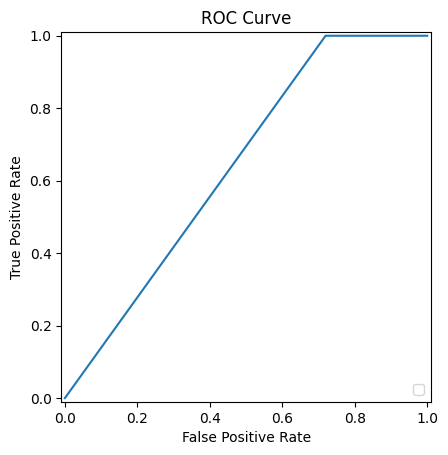

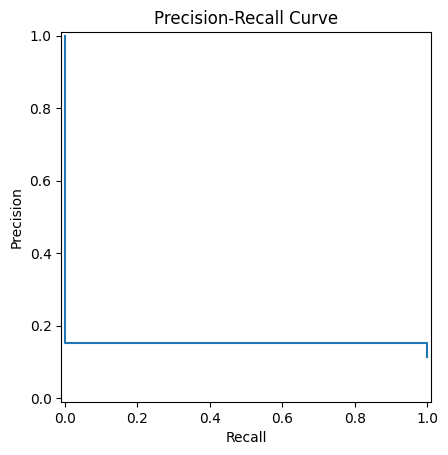

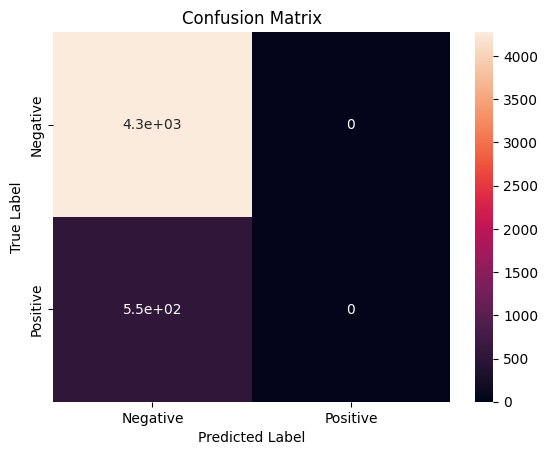

(0.8864248704663212,
 0.0,
 0.6402852466682254,
 '              precision    recall  f1-score   support\n\n         0.0       0.89      1.00      0.94      4277\n         1.0       0.00      0.00      0.00       548\n\n    accuracy                           0.89      4825\n   macro avg       0.44      0.50      0.47      4825\nweighted avg       0.79      0.89      0.83      4825\n',
 0.8880829015544041,
 0.641661264531743)

In [35]:
train_score_model(RandomForestClassifier(random_state=1), X_train, X_test, y_train, y_test)

Okay so the results show that the model is not working properly. The recall and F1 are both 0. As this is predictive maintenance, we are mainly focussed on the recall score. A ROC_AUC of 0.64 is only slightly better than random. The model needs more predictor variables. In addition, a class imbalance could be causing the model failure. 

In [36]:
#Lets work on the pressure df
df.head()

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


In [37]:
df['cycle_code'] = df['MachineId'] + '_' + df['MeasurementId'].astype('str')

In [38]:
df.head()

,MachineId,MeasurementId,Pressure,cycle_code
0,0_0_0,0,0.0,0_0_0_0
1,0_0_0,0,0.0,0_0_0_0
2,0_0_0,0,0.0,0_0_0_0
3,0_0_0,0,0.0,0_0_0_0
4,0_0_0,0,0.0,0_0_0_0


In [39]:
#First lets see how many pressure values are measured per cycle
pressure_count = df.groupby('cycle_code')['Pressure'].count().reset_index()
pressure_count.columns = ['cycle_code', 'pressure_count']

In [40]:
pressure_count.describe()

,pressure_count
count,27385.000000
mean,674.324046
std,3651.210385
min,93.000000
25%,354.000000
50%,438.000000
75%,579.000000
max,185476.000000


So it seems maybe the pressure sensor was left on for some of the machines for too long. There are many maximum outliers. 

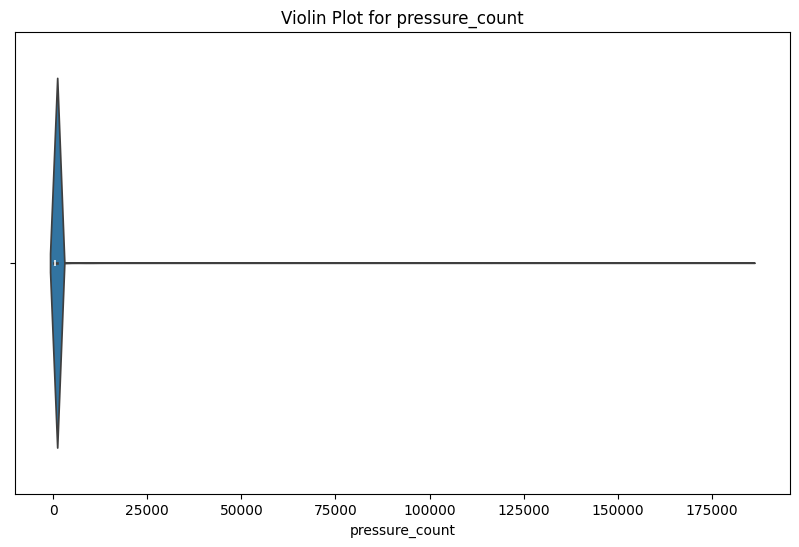

In [41]:
# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='pressure_count', data=pressure_count)
plt.title('Violin Plot for pressure_count')
plt.xlabel('pressure_count')
plt.show()

The violinplot shows this clearly. Lets set a threshold and delete all pressure counts above 10 000 and see. 

In [42]:
high_cycle_count = pressure_count.loc[pressure_count['pressure_count'] > 1500, 'cycle_code']

In [43]:
high_cycle_count.head()

0       0_0_0_-1
570     0_0_1_-1
1155    0_0_2_-1
1753    0_0_3_-1
2378    0_1_0_-1
Name: cycle_code, dtype: object

In [44]:
pressure_count_filtered = pressure_count[~pressure_count['cycle_code'].isin(high_cycle_count)]

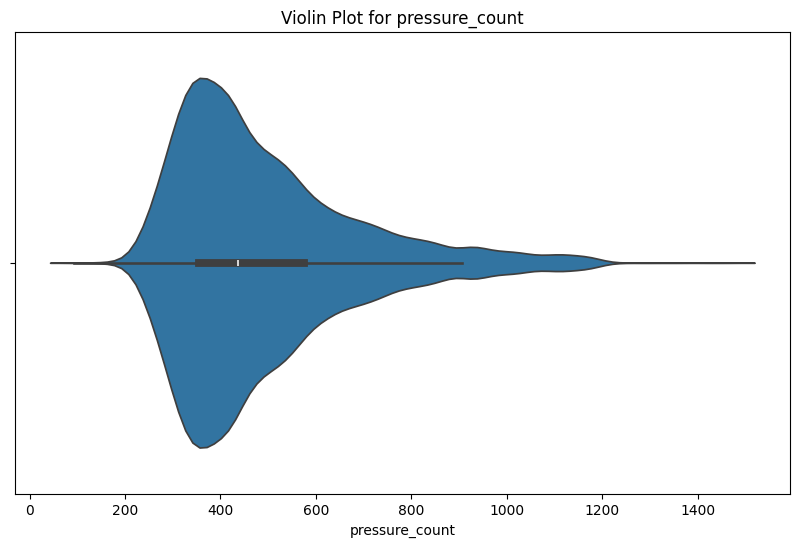

In [45]:
# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='pressure_count', data=pressure_count_filtered)
plt.title('Violin Plot for pressure_count')
plt.xlabel('pressure_count')
plt.show()

I first set the max pressure cycle value to 10 000 but then reduced it to 1500 after looking at the violin plot. If we knew the length of time between each measurement we could tweek this better (as we would knpow what a reasonable machine cycle length would be)

In [46]:
#Creating a new df without the cycles that are over 1500 measurements long.
df_filtered = df[~df['cycle_code'].isin(high_cycle_count)]

However, a better method might be to delete all the zero values from the df. I am not sure exactly if this is the best method as a machine with many zero values at the beginning might be slower to start which could also indicate machine failure. But for now I will assume not and delete the zero values. 

In [47]:
df_filtered = df_filtered[df_filtered['Pressure'] != 0]

In [48]:
df_filtered

,MachineId,MeasurementId,Pressure,cycle_code
85,0_0_0,0,0.439806,0_0_0_0
86,0_0_0,0,1.022330,0_0_0_0
87,0_0_0,0,0.923301,0_0_0_0
88,0_0_0,0,1.413592,0_0_0_0
89,0_0_0,0,0.923301,0_0_0_0
...,...,...,...,...
18466277,10_0_3,8834,0.300457,10_0_3_8834
18466278,10_0_3,8834,0.237443,10_0_3_8834
18466279,10_0_3,8834,0.169863,10_0_3_8834
18466280,10_0_3,8834,0.090411,10_0_3_8834


In [49]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5542923 entries, 85 to 18466281
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  object 
 2   Pressure       float64
 3   cycle_code     object 
dtypes: float64(1), object(3)
memory usage: 211.4+ MB


In [50]:
#Initialising a new df
df_vars = pd.DataFrame()

In [51]:
#Adding in the cycle_code column for the new df
df_vars['cycle_code'] = df_filtered['cycle_code'].unique()
df_vars.head()

,cycle_code
0,0_0_0_0
1,0_0_2_0
2,0_0_3_0
3,0_1_1_1
4,1_0_0_2


Now lets create some new predictor variables

In [52]:
mean_vals = df_filtered.groupby('cycle_code')['Pressure'].mean().reset_index()
mean_vals.columns = ['cycle_code', 'mean_pressure']
std_vals = df_filtered.groupby('cycle_code')['Pressure'].std().reset_index()
std_vals.columns = ['cycle_code', 'std_pressure']
max_vals = df_filtered.groupby('cycle_code')['Pressure'].max().reset_index()
max_vals.columns = ['cycle_code', 'max_pressure']
skew_vals = df_filtered.groupby('cycle_code')['Pressure'].skew().reset_index()
skew_vals.columns = ['cycle_code', 'skewness']

In [53]:
#And add them to the df_vars df
df_vars = pd.merge(df_vars, mean_vals, on='cycle_code', how='left')
df_vars = pd.merge(df_vars, std_vals, on='cycle_code', how='left')
df_vars = pd.merge(df_vars, max_vals, on='cycle_code', how='left')
df_vars = pd.merge(df_vars, skew_vals, on='cycle_code', how='left')


In [54]:
df_vars.head()

,cycle_code,mean_pressure,std_pressure,max_pressure,skewness
0,0_0_0_0,1.014906,0.349993,1.584466,-1.237842
1,0_0_2_0,0.820910,0.188122,1.205104,-1.386915
2,0_0_3_0,0.948806,0.367615,1.497921,-1.326280
3,0_1_1_1,1.000889,0.272449,1.470103,-1.629540
4,1_0_0_2,0.960974,0.359026,1.462193,-1.134642


In [55]:
#now lets work off the first half of the cycle. (This code was made using ChatGPT)
cycle_lengths = df_filtered.groupby('cycle_code')['Pressure'].transform('count')
first_half_index = (cycle_lengths // 2).astype(int)
df_first_half = df_filtered[df_filtered.groupby(['MachineId', 'MeasurementId']).cumcount() < first_half_index]

In [56]:
print((len(df_filtered)) / (len(df_first_half)))

2.004912338574825


So we have halved the len of the df_filtered. Now lets create the same predictor descriptive stats as before but now with the first half of the dataset


In [57]:
mean_vals_fh = df_first_half.groupby('cycle_code')['Pressure'].mean().reset_index()
mean_vals_fh.columns = ['cycle_code', 'fh_mean_pressure']
std_vals_fh = df_first_half.groupby('cycle_code')['Pressure'].std().reset_index()
std_vals_fh.columns = ['cycle_code', 'fh_std_pressure']
max_vals_fh = df_first_half.groupby('cycle_code')['Pressure'].max().reset_index()
max_vals_fh.columns = ['cycle_code', 'fh_max_pressure']
skew_vals_fh = df_first_half.groupby('cycle_code')['Pressure'].skew().reset_index()
skew_vals_fh.columns = ['cycle_code', 'fh_skewness']

In [58]:
df_vars = pd.merge(df_vars, mean_vals_fh, on='cycle_code', how='left')
df_vars = pd.merge(df_vars, std_vals_fh, on='cycle_code', how='left')
df_vars = pd.merge(df_vars, max_vals_fh, on='cycle_code', how='left')
df_vars = pd.merge(df_vars, skew_vals_fh, on='cycle_code', how='left')

In [59]:
df_vars.head()

,cycle_code,mean_pressure,std_pressure,max_pressure,skewness,fh_mean_pressure,fh_std_pressure,fh_max_pressure,fh_skewness
0,0_0_0_0,1.014906,0.349993,1.584466,-1.237842,1.141348,0.225699,1.584466,-0.292531
1,0_0_2_0,0.820910,0.188122,1.205104,-1.386915,0.818812,0.162229,1.205104,0.146517
2,0_0_3_0,0.948806,0.367615,1.497921,-1.326280,0.997744,0.267320,1.410603,-1.962601
3,0_1_1_1,1.000889,0.272449,1.470103,-1.629540,0.995998,0.208694,1.382474,-0.599174
4,1_0_0_2,0.960974,0.359026,1.462193,-1.134642,0.896080,0.402125,1.462193,-0.715398


In [60]:
df_first_half.head()

,MachineId,MeasurementId,Pressure,cycle_code
85,0_0_0,0,0.439806,0_0_0_0
86,0_0_0,0,1.022330,0_0_0_0
87,0_0_0,0,0.923301,0_0_0_0
88,0_0_0,0,1.413592,0_0_0_0
89,0_0_0,0,0.923301,0_0_0_0


I have created the code below to save a dictionary of the max drop between 20 measurements for each cycle. However, the code took too long to run and I stopped it. I then used ChatGPT to create new code which would run faster. 

In [61]:
unique_cycle_code = df_first_half['cycle_code'].unique()
max_gaps = {}
gap = 20

for cycle_code in unique_cycle_code:
    max_gap = 0
    cycle_df = df_first_half[df_first_half['cycle_code'] == cycle_code]

    for idx in range(len(cycle_df) -gap):
        cur_val = df_first_half['Pressure'].iloc[idx]
        fut_val = df_first_half['Pressure'].iloc[idx+gap]
        cur_gap = cur_val - fut_val
        if cur_gap > max_gap:
            max_gap = cur_gap
    max_gaps[cycle_code] = max_gap

KeyboardInterrupt: 

In [62]:
df_first_half.dtypes

MachineId         object
MeasurementId     object
Pressure         float64
cycle_code        object
dtype: object

We could change the pressure type to float 32 to reduce data size but we may loose precision. Now lets calculate the rolling maximum pressure drop per cycle.

In [63]:
gap = 20

# Assuming df_first_half is your DataFrame
# Sort by cycle_code and MeasurementId to ensure a correct order for the rolling operation
df_first_half_sorted = df_first_half.sort_values(['cycle_code', 'MeasurementId'])

# Calculate the rolling maximum pressure drop for each unique cycle_code
df_vars['max_gap'] = (
    df_first_half_sorted.groupby('cycle_code')['Pressure']
    .rolling(window=gap, min_periods=1)
    .apply(lambda x: x[:-1].max() - x.iloc[-1], raw=False)
    .reset_index(level=0, drop=True)
)

In [64]:
df_vars.max_gap.describe()

count    2731.000000
mean        0.146916
std         0.216544
min        -1.063983
25%         0.026644
50%         0.101917
75%         0.214219
max         1.547689
Name: max_gap, dtype: float64

In [65]:
#The max pressure drop shouldnt be negative, so I am going to convert all negative values to 0. 
df_vars['max_gap'] = df_vars['max_gap'].clip(lower=0)

In [66]:
df_vars.max_gap.describe()

count    2731.000000
mean        0.159466
std         0.198335
min         0.000000
25%         0.026644
50%         0.101917
75%         0.214219
max         1.547689
Name: max_gap, dtype: float64

In [67]:
#Now lets calculate the max pressure drop over 10 pressure measurements:
gap = 10

# Assuming df_first_half is your DataFrame
# Sort by cycle_code and MeasurementId to ensure a correct order for the rolling operation
df_first_half_sorted = df_first_half.sort_values(['cycle_code', 'MeasurementId'])

# Calculate the rolling maximum pressure drop for each unique cycle_code
df_vars['max_gap_10'] = (
    df_first_half_sorted.groupby('cycle_code')['Pressure']
    .rolling(window=gap, min_periods=1)
    .apply(lambda x: x[:-1].max() - x.iloc[-1], raw=False)
    .reset_index(level=0, drop=True)
)

In [68]:
df_vars['max_gap_10'] = df_vars['max_gap_10'].clip(lower=0)

In [69]:
df_vars.max_gap_10.describe()

count    2731.000000
mean        0.121470
std         0.158362
min         0.000000
25%         0.005608
50%         0.071561
75%         0.170532
max         1.456244
Name: max_gap_10, dtype: float64

In [71]:
df_vars.max_gap.isnull().sum()

24354

There are many null values and I can't get it to work so I will have to drop the columns

In [73]:
df_vars = df_vars.drop(['max_gap', 'max_gap_10'], axis=1)

# Data Processing
- now lets imput the most frequent values for SlowStart and SlowEnd into the missing values.

In [74]:
from sklearn.impute import SimpleImputer
#Lets imput the missing SlowStart and SlowEnd labels with modal scores. 
labels_copy_imput = labels.copy()
imputer = SimpleImputer(strategy='most_frequent')
labels_copy_imput[['SlowStart']] = imputer.fit_transform(labels[['SlowStart']])
labels_copy_imput[['SlowEnd']] = imputer.fit_transform(labels[['SlowEnd']])

In [75]:
labels_copy_imput.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,cycle_code
0,0_0_0,0,False,0.0,0.0,0_0_0_0
2,0_0_2,0,False,0.0,0.0,0_0_2_0
3,0_0_3,0,True,0.0,0.0,0_0_3_0
5,0_1_1,1,True,0.0,0.0,0_1_1_1
8,1_0_0,2,False,1.0,0.0,1_0_0_2


In [76]:
merged_df = pd.merge(labels_copy_imput, df_vars, on='cycle_code', how='left')

In [77]:
merged_df = merged_df.reset_index(drop=True)

In [78]:
merged_df.columns

Index(['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd',
       'cycle_code', 'mean_pressure', 'std_pressure', 'max_pressure',
       'skewness', 'fh_mean_pressure', 'fh_std_pressure', 'fh_max_pressure',
       'fh_skewness'],
      dtype='object')

In [79]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26900 entries, 0 to 26899
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MachineId         26900 non-null  category
 1   MeasurementId     26900 non-null  category
 2   PumpFailed        26900 non-null  category
 3   SlowStart         26900 non-null  float64 
 4   SlowEnd           26900 non-null  float64 
 5   cycle_code        26900 non-null  object  
 6   mean_pressure     26838 non-null  float64 
 7   std_pressure      26837 non-null  float64 
 8   max_pressure      26838 non-null  float64 
 9   skewness          26834 non-null  float64 
 10  fh_mean_pressure  26837 non-null  float64 
 11  fh_std_pressure   26831 non-null  float64 
 12  fh_max_pressure   26837 non-null  float64 
 13  fh_skewness       26830 non-null  float64 
dtypes: category(3), float64(10), object(1)
memory usage: 2.7+ MB


In [81]:
merged_df['fh_skewness'].fillna(merged_df['fh_skewness'].mean(), inplace=True)
merged_df['fh_max_pressure'].fillna(merged_df['fh_max_pressure'].mean(), inplace=True)
merged_df['fh_std_pressure'].fillna(merged_df['fh_std_pressure'].mean(), inplace=True)
merged_df['fh_mean_pressure'].fillna(merged_df['fh_mean_pressure'].mean(), inplace=True)
merged_df['skewness'].fillna(merged_df['skewness'].mean(), inplace=True)
merged_df['max_pressure'].fillna(merged_df['max_pressure'].mean(), inplace=True)
merged_df['std_pressure'].fillna(merged_df['std_pressure'].mean(), inplace=True)
merged_df['mean_pressure'].fillna(merged_df['mean_pressure'].mean(), inplace=True)

In [82]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26900 entries, 0 to 26899
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MachineId         26900 non-null  category
 1   MeasurementId     26900 non-null  category
 2   PumpFailed        26900 non-null  category
 3   SlowStart         26900 non-null  float64 
 4   SlowEnd           26900 non-null  float64 
 5   cycle_code        26900 non-null  object  
 6   mean_pressure     26900 non-null  float64 
 7   std_pressure      26900 non-null  float64 
 8   max_pressure      26900 non-null  float64 
 9   skewness          26900 non-null  float64 
 10  fh_mean_pressure  26900 non-null  float64 
 11  fh_std_pressure   26900 non-null  float64 
 12  fh_max_pressure   26900 non-null  float64 
 13  fh_skewness       26900 non-null  float64 
dtypes: category(3), float64(10), object(1)
memory usage: 2.7+ MB


In [83]:
#Change the SlowStart and SlowEnd columns to ints
merged_df['SlowStart'] = merged_df['SlowStart'].astype(int)
merged_df['SlowEnd'] = merged_df['SlowEnd'].astype(int)

In [86]:
# Split into X and y
X = merged_df[['SlowStart', 'SlowEnd',
        'mean_pressure', 'std_pressure', 'max_pressure',
       'skewness', 'fh_mean_pressure', 'fh_std_pressure', 'fh_max_pressure',
       'fh_skewness', ]]
y = merged_df['PumpFailed']

In [87]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26900 entries, 0 to 26899
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SlowStart         26900 non-null  int32  
 1   SlowEnd           26900 non-null  int32  
 2   mean_pressure     26900 non-null  float64
 3   std_pressure      26900 non-null  float64
 4   max_pressure      26900 non-null  float64
 5   skewness          26900 non-null  float64
 6   fh_mean_pressure  26900 non-null  float64
 7   fh_std_pressure   26900 non-null  float64
 8   fh_max_pressure   26900 non-null  float64
 9   fh_skewness       26900 non-null  float64
dtypes: float64(8), int32(2)
memory usage: 1.8 MB


In [88]:
X.head()

,SlowStart,SlowEnd,mean_pressure,std_pressure,max_pressure,skewness,fh_mean_pressure,fh_std_pressure,fh_max_pressure,fh_skewness
0,0,0,1.014906,0.349993,1.584466,-1.237842,1.141348,0.225699,1.584466,-0.292531
1,0,0,0.820910,0.188122,1.205104,-1.386915,0.818812,0.162229,1.205104,0.146517
2,0,0,0.948806,0.367615,1.497921,-1.326280,0.997744,0.267320,1.410603,-1.962601
3,0,0,1.000889,0.272449,1.470103,-1.629540,0.995998,0.208694,1.382474,-0.599174
4,1,0,0.960974,0.359026,1.462193,-1.134642,0.896080,0.402125,1.462193,-0.715398


In [89]:
y.head()

0    False
1    False
2     True
3     True
4    False
Name: PumpFailed, dtype: category
Categories (2, bool): [False, True]

In [90]:
# Change y to int
y = y.astype(int)

In [91]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: PumpFailed, dtype: int32

In [92]:
# Now lets apply the standard scaler to transform the data to have a mean of 0 and a std of 1. 
# This mainly works for gradient descent boosting models and K-means, but is a common ML data processing step
# and can improve other model performance as well. 
from sklearn.preprocessing import StandardScaler
#Split data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

# Standardize your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [93]:
# To address the class imbalance we will use SMOTE to create new instances of the minority class (when the pump failed)
from imblearn.over_sampling import SMOTE

#Apply smote
smote = SMOTE(random_state=1)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

In [94]:
y_resampled.isnull().sum()

0

In [95]:
#Check the counts are the same
num_zeros = np.sum(y_resampled == 0)
num_ones = np.sum(y_resampled == 1)

# Print the counts
print(f"Number of 0's: {num_zeros}")
print(f"Number of 1's: {num_ones}")

Number of 0's: 19183
Number of 1's: 19183


Test which model performs the best

In [99]:
#We will just use a random forest model
# Lets import some models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC #although this model is computationally intensive and will take up a lot of time to run
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier #a very light model suitable for large datasets
from sklearn.neighbors import KNeighborsClassifier


So the model aims to predict machine failure. The cost of not predicting the machine failing is high (false negative). Therefore we are focussing on recall here as we want to reduce false. This might even mean we have to accept more false positives which means the mechanic has to check the machine even if it is okay. This is very condition dependent. 

The model running: LogisticRegression()


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.887546468401487
Recall score: 0.0
F1 score: 0.0
Classification report:               precision    recall  f1-score   support

           0       0.89      1.00      0.94      4775
           1       0.00      0.00      0.00       605

    accuracy                           0.89      5380
   macro avg       0.44      0.50      0.47      5380
weighted avg       0.79      0.89      0.83      5380

ROC_AUC score: 0.7970448704080308
Cross-validation score: 0.9061338289962825
Cross-validation ROC AUC score: 0.8657350048170999


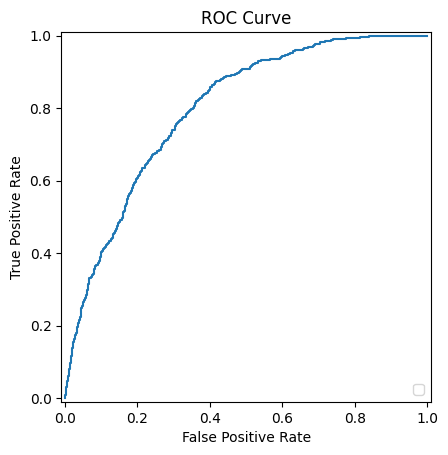

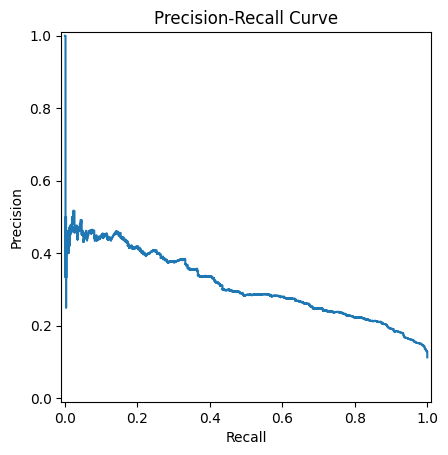

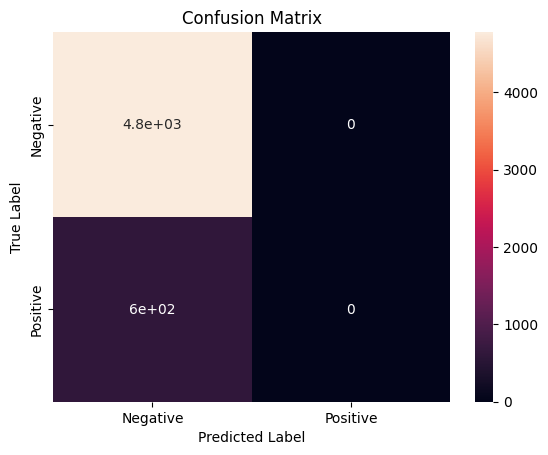

The model running: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8425650557620817
Recall score: 0.1024793388429752
F1 score: 0.12770339855818744
Classification report:               precision    recall  f1-score   support

           0       0.89      0.94      0.91      4775
           1       0.17      0.10      0.13       605

    accuracy                           0.84      5380
   macro avg       0.53      0.52      0.52      5380
weighted avg       0.81      0.84      0.83      5380

ROC_AUC score: 0.579067457055082
Cross-validation score: 0.9116356877323419
Cross-validation ROC AUC score: 0.8791241999426525


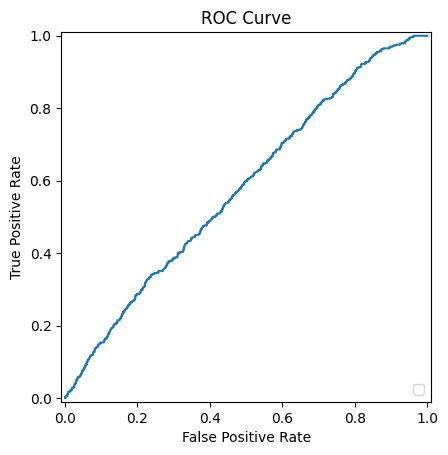

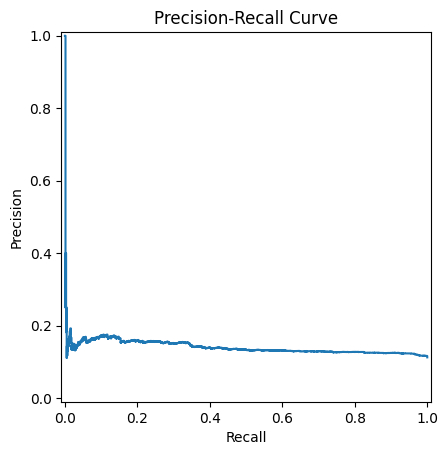

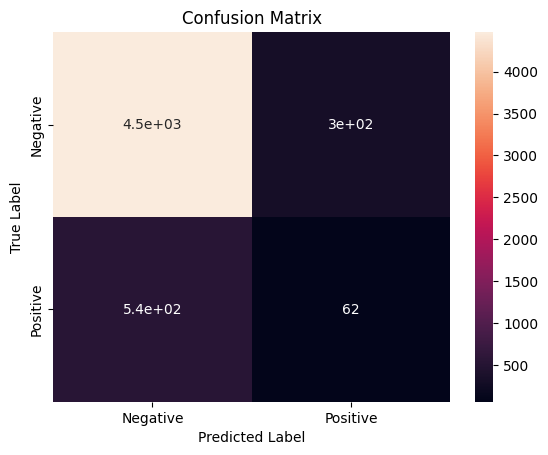

The model running: LGBMClassifier(force_col_wise=True)
[LightGBM] [Info] Number of positive: 19183, number of negative: 19183
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 38366, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2354, number of negative: 19166
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 21520, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109387 -> initscore=-2.097022
[LightGBM] [Info] Start training from score -2.097022
[LightGBM] [Info] Number of positive: 2354, number of negative: 19166
[LightGBM] [Info] Total Bins 2044
[LightGBM] [Info] Number of data points in the train set: 21520, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109387 -> initscore=-2.097022
[LightGBM] [Info] Start training from score -2.097022
[Light

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8838289962825279
Recall score: 0.013223140495867768
F1 score: 0.0249609984399376
Classification report:               precision    recall  f1-score   support

           0       0.89      0.99      0.94      4775
           1       0.22      0.01      0.02       605

    accuracy                           0.88      5380
   macro avg       0.56      0.50      0.48      5380
weighted avg       0.81      0.88      0.84      5380

ROC_AUC score: 0.7076917485180217
Cross-validation score: 0.9139776951672862
Cross-validation ROC AUC score: 0.8852052242688263


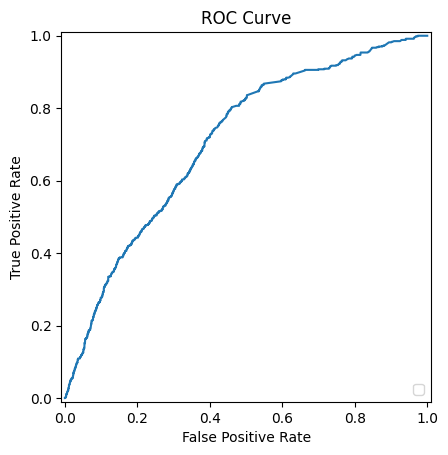

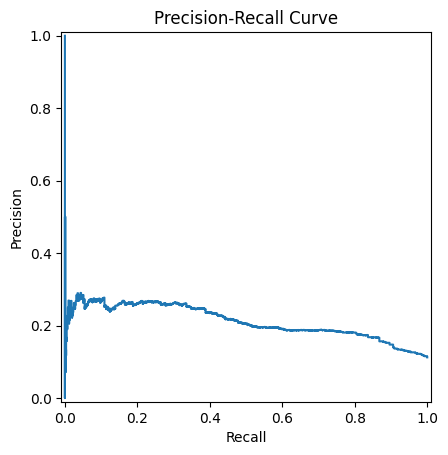

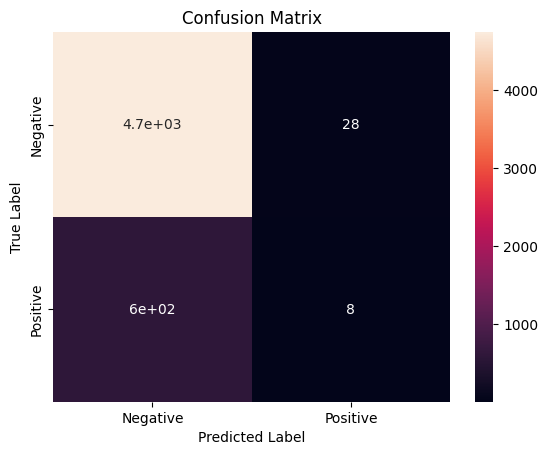

The model running: RandomForestClassifier()


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8871747211895911
Recall score: 0.003305785123966942
F1 score: 0.006546644844517185
Classification report:               precision    recall  f1-score   support

           0       0.89      1.00      0.94      4775
           1       0.33      0.00      0.01       605

    accuracy                           0.89      5380
   macro avg       0.61      0.50      0.47      5380
weighted avg       0.83      0.89      0.84      5380

ROC_AUC score: 0.5530123317900567
Cross-validation score: 0.9147211895910781
Cross-validation ROC AUC score: 0.8681313659354444


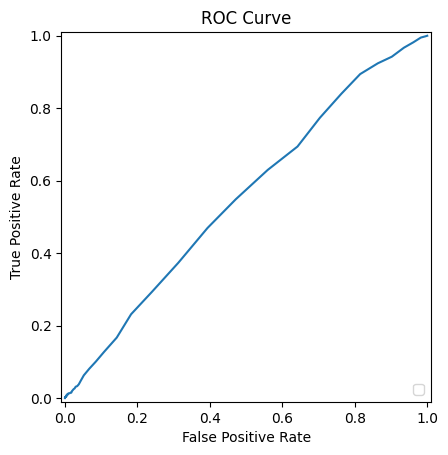

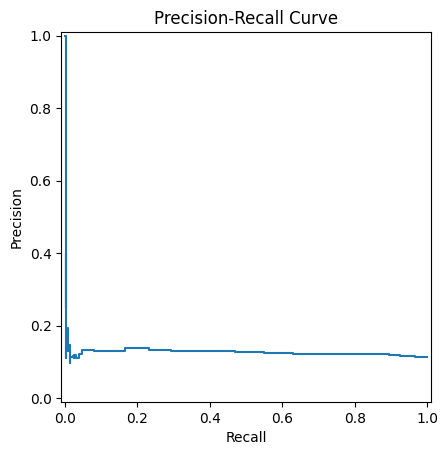

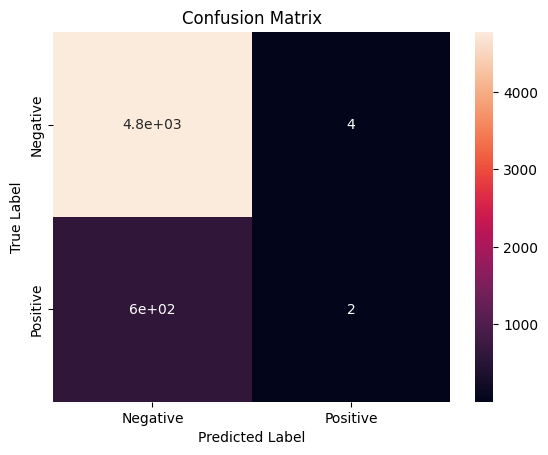

The model running: KNeighborsClassifier()


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.8672862453531599
Recall score: 0.01818181818181818
F1 score: 0.029891304347826088
Classification report:               precision    recall  f1-score   support

           0       0.89      0.97      0.93      4775
           1       0.08      0.02      0.03       605

    accuracy                           0.87      5380
   macro avg       0.49      0.50      0.48      5380
weighted avg       0.80      0.87      0.83      5380

ROC_AUC score: 0.47932655445458877
Cross-validation score: 0.9014126394052043
Cross-validation ROC AUC score: 0.7859075845124093


c:\Users\mslam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


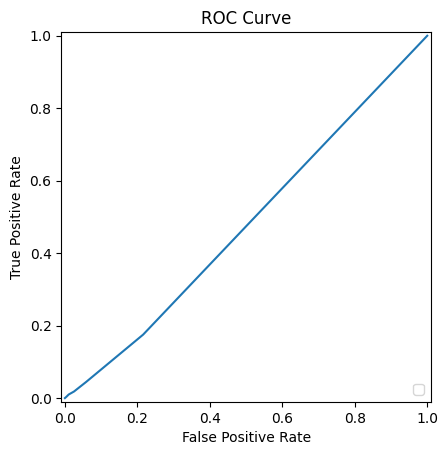

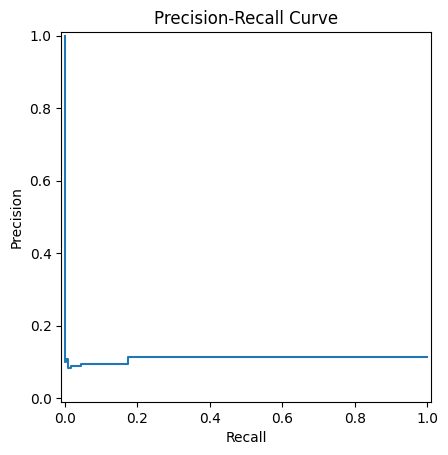

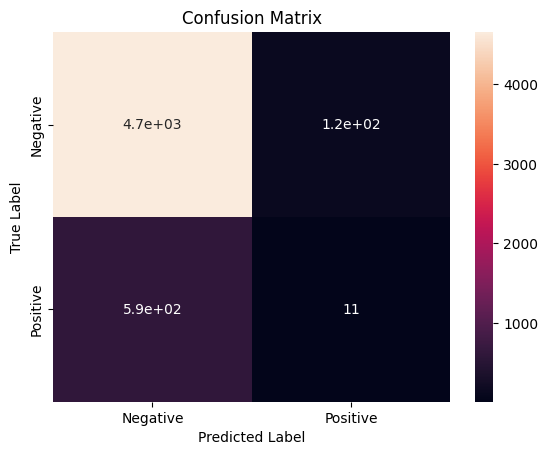

In [102]:
models = [LogisticRegression(), XGBClassifier(), LGBMClassifier(force_col_wise=True), RandomForestClassifier(), KNeighborsClassifier()]

for mod in models:
    print(f'The model running: {mod}')
    train_score_model(mod, X_resampled, X_test, y_resampled, y_test)

Each model showed very different results for precision, recall, and F1. The results are not good (probably due to the fact that I could not get the max decrease to work). I will chose the XGBClassifier model as the best model since it has the highest recall rate which is useful in predicting if a machine failed. Based on these results, lets tune the hypeparameters of this model. I could have selected more a wider range of hyperparameters for n_estimators and learning_rate and then narrowed down on on a subsequent grid search but this would take too much time.

In [106]:
from sklearn.model_selection import GridSearchCV
#Grid Search
param_grid = {'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 1000],
    'max_depth': [5]}
    

xg = XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, cv=5, scoring='recall', verbose=1)

# Fit the model to the data
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_xg = grid_search.best_estimator_

# Make predictions using the best model
pred_best_xg = best_xg.predict(X_test)

# Print classification report and accuracy
print(classification_report(y_test, pred_best_xg))
print(f"XG accuracy score {accuracy_score(y_test, pred_best_xg) * 100}%")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4775
           1       0.13      0.03      0.05       605

    accuracy                           0.87      5380
   macro avg       0.51      0.50      0.49      5380
weighted avg       0.80      0.87      0.83      5380

XG accuracy score 86.91449814126393%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8691449814126394
Recall score: 0.02809917355371901
F1 score: 0.04607046070460705
Classification report:               precision    recall  f1-score   support

           0       0.89      0.98      0.93      4775
           1       0.13      0.03      0.05       605

    accuracy                           0.87      5380
   macro avg       0.51      0.50      0.49      5380
weighted avg       0.80      0.87      0.83      5380

ROC_AUC score: 0.6180994331703518
Cross-validation score: 0.908921933085502
Cross-validation ROC AUC score: 0.8745429908765316


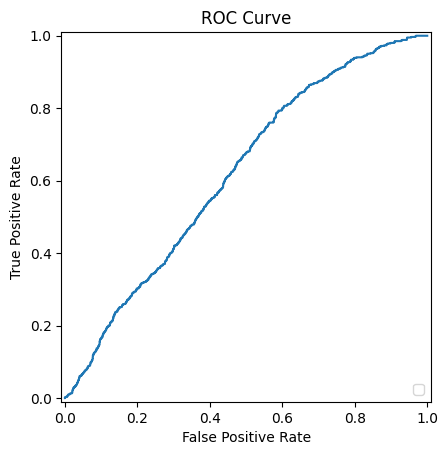

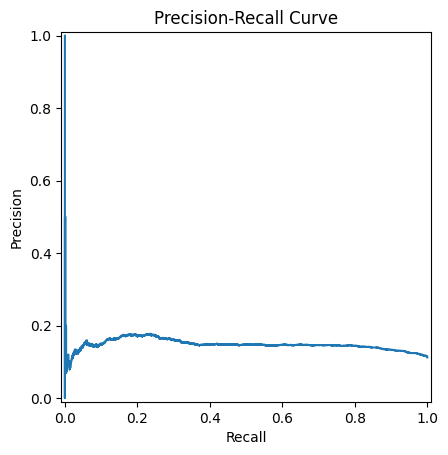

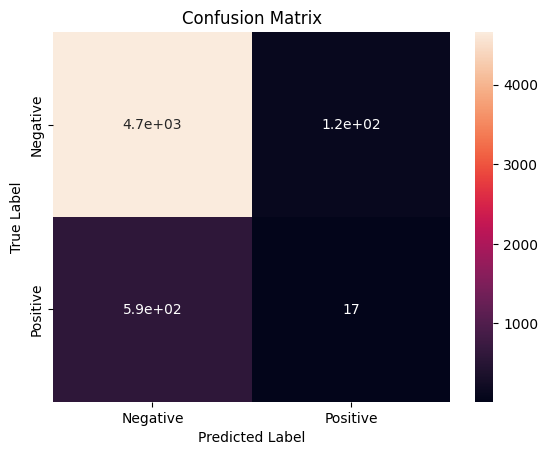

(0.8691449814126394,
 0.04607046070460705,
 0.6180994331703518,
 '              precision    recall  f1-score   support\n\n           0       0.89      0.98      0.93      4775\n           1       0.13      0.03      0.05       605\n\n    accuracy                           0.87      5380\n   macro avg       0.51      0.50      0.49      5380\nweighted avg       0.80      0.87      0.83      5380\n',
 0.908921933085502,
 0.8745429908765316)

In [109]:
train_score_model(best_xg, X_resampled, X_test, y_resampled, y_test)

The tuned hyperparameters actually decreased the recall. So better hyperparameters should be selected. 

So to finish off the assignment. The code is very long but I left in my working to show my thought process. I should have spent more time working on code to get the max pressure decrease which may have helped my model. Regarding the output of the best model:
- The accuracy isnt a good predictor since there is such a class imbalance.
- Recall is high (90%) which is good for the model as this is showing the percentage of positives the model predicted correct of all positive cases. 
- Precision is low (12%) so the model is predicting many more positives than were actually present.
- F1 is a harmonic mean of Precision and Recall and shows the impact of the low Precision. 
- The ROC-AUC is not good as it predicts just better than random. 

I am not happy with how the model performed and should have spent more time with engineering new features which could be good predictors of machine failure or success. 
Options for improvement:
- Use a neural network such as the tensflow sequential model.
- Worked on engineering more pressure drop predictors from the first half of the pressure cycle
- More complex pressure drop predictors could take the first max value after the machine starts and then caluclate the drop after that max value (until the pressure starts rising again). Then the count of pressure measurements could also be considered (so the length of time the pressure drops for)
- Adding in measurementId is a good predictor of whether the machine failed or not. This could be considered if it doesnt present data leakage.
- Deleting the zeros from the start of the machine cycle may not be a good idea as they could have also been predictors of a machine failure and investigating this would have taken too much time and thus was beyond the scope of this project. 